# Откриване на регистрационна табела в снимка на кола и генериране на dataset с изображения на символи от регистрационни табели



In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
import random
import math
from glob import glob

In [2]:
image = cv2.imread("example.jpg")
image_copy = image
image_height, image_width = image.shape[:2]
print(image_width)
print(image_height)

800
600


In [3]:
plt.rcParams["figure.figsize"] = (30,25)

In [4]:
def show_image(image, name='image'):
    while(True):

        # Display the resulting frame
        cv2.imshow(name, image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cv2.destroyAllWindows()

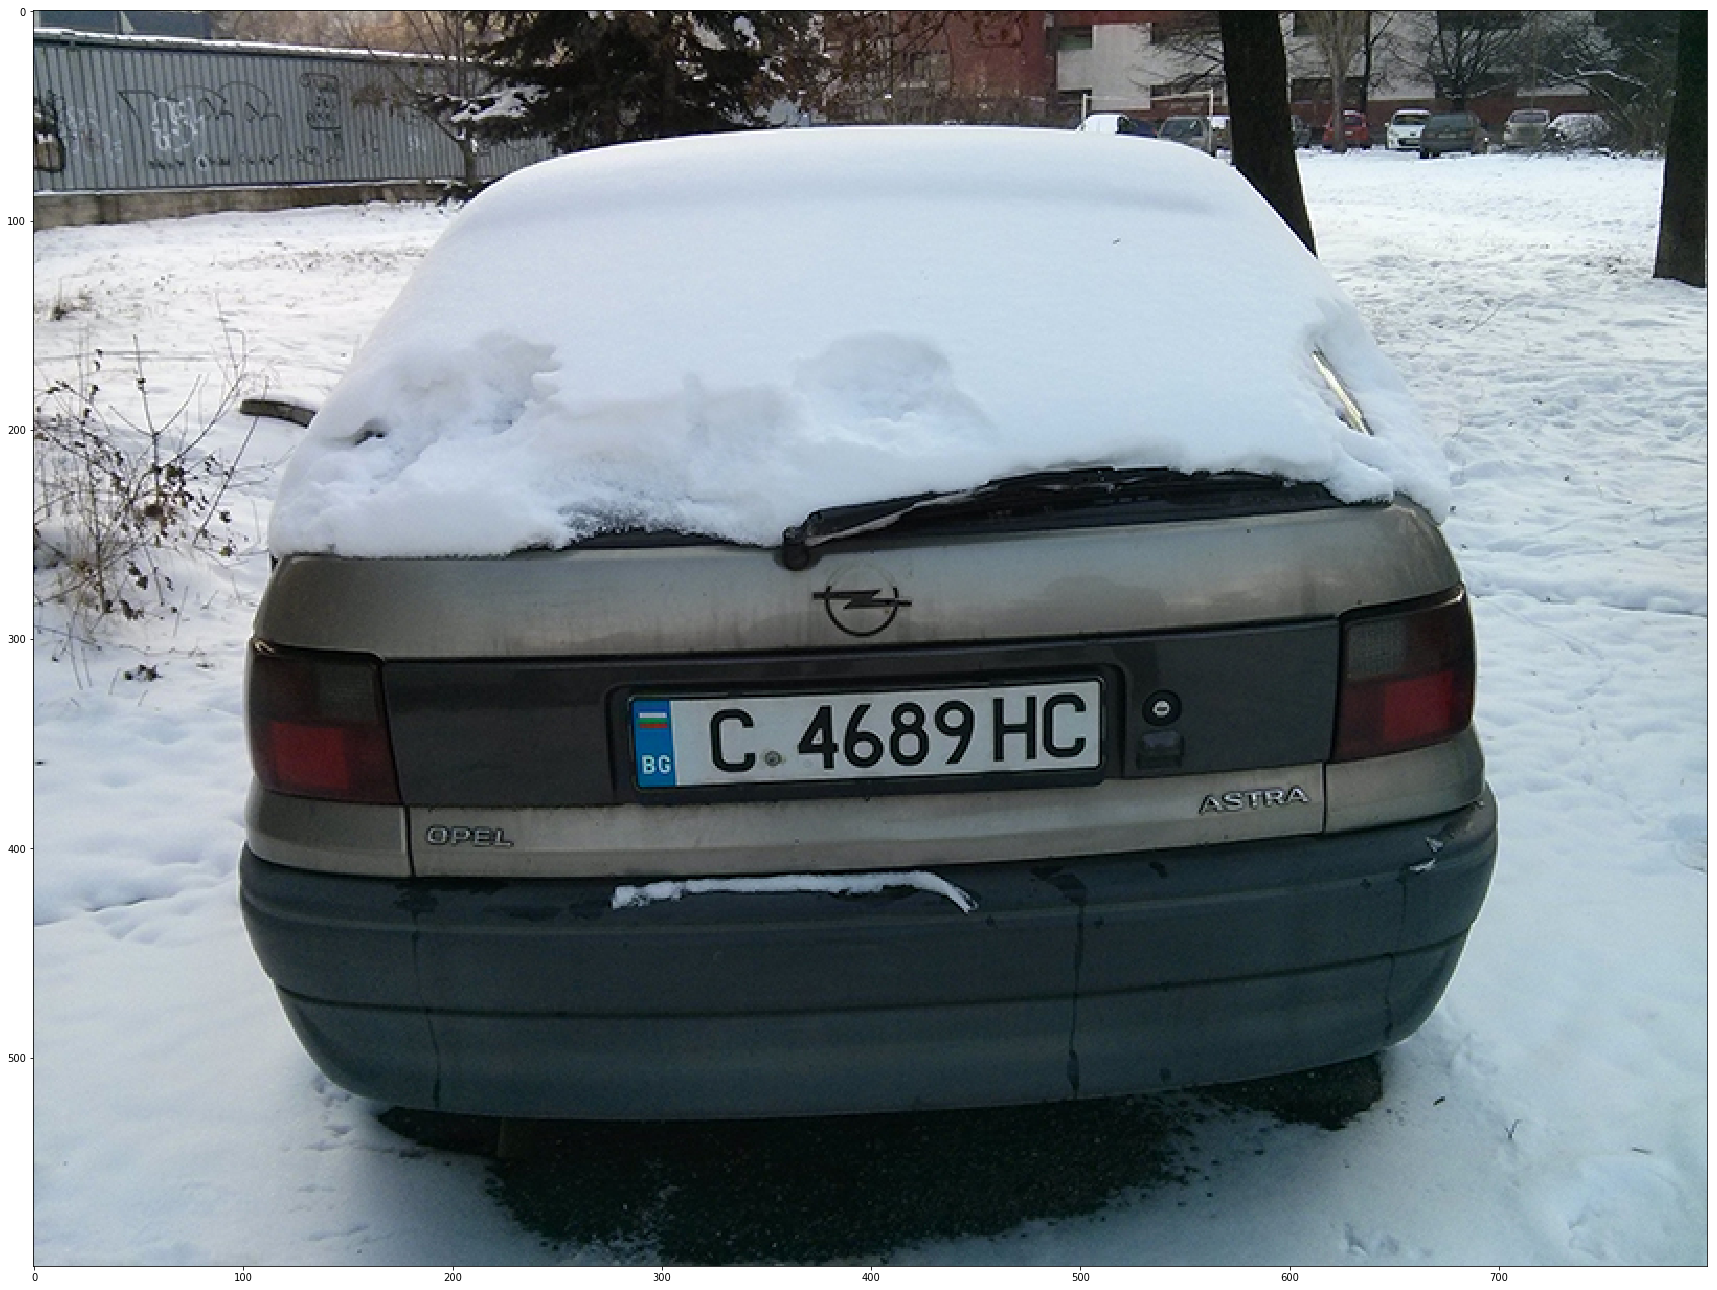

In [5]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()

### Първоначално изображението минава през няколко функции (филтъра).

Първо използваме Gaussian Blur 5x5 за премахване на шум от изображението.

Тъй като знаем, че в една регистрационна табела има много вертикални линии (заради символите), трябва да приложим Sobel филтър, който създава изображение, в което се набляга на линиите.

Следва Threshold филтър по метода на Otsu, който трансформира изображението от 8 битово (grayscale) в двоично (черно-бяло).

Прилагаме Close Morphological Operation, за да премахнем празните пространства между вертикалните линии като по този начин свързваме всички региони с голям брой вертикални линии.

След прилагането на всички тези операции получаваме изображение, в което има региони, които биха съдържали регистрационна табела. Не всички от тях са валидни. Използвайки функцията findContours можем да получим всички отделни региони.

In [6]:
def filter_image(image):
    contours = []
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('test_1.png',image_gray)
    show_image(image_gray)
    
    image_blurred = cv2.blur(image_gray, (5,5))
    cv2.imwrite('test_2.png',image_blurred)
    show_image(image_blurred)
    
    image_sobel = cv2.Sobel(image_blurred, cv2.CV_8U, 1, 0)
    cv2.imwrite('test_3.png',image_sobel)
    show_image(image_sobel)
    
    result, image_threshold = cv2.threshold(image_sobel,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cv2.imwrite('test_4.png', image_threshold)
    show_image(image_threshold)
    
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (17,3))
    image_threshold = cv2.morphologyEx(image_threshold, cv2.MORPH_CLOSE, element)
    cv2.imwrite('test_5.png', image_threshold)
    show_image(image_threshold)
    
    im2, contours, hierarchy = cv2.findContours(image_threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    
    return contours

In [7]:
def check_size(rect):
    width = float(rect[1][0])
    height = float(rect[1][1])
    aspect_ratio = 52.0/11.0
    error_rate = 0.4
    min_area = float(15 * aspect_ratio * 15)
    
    max_area = float(125 * aspect_ratio * 125)
    
    ratioMin = float(aspect_ratio - (aspect_ratio * error_rate))
    ratioMax = float(aspect_ratio + (aspect_ratio * error_rate))
    
    area = (height) * width
    ratio = width / (height + 0.0000000000000001)
    if(ratio != 0 and ratio < 1):
        ratio = 1/ratio
        
    if( ((area >= min_area) and (area <= max_area)) and ((ratio >= ratioMin) and (ratio <= ratioMax)) ):
        return True

    return False

За всеки контур намираме минималния правоъгълник, в който се намира чрез minAreaRect. След това чрез функцията check_size, проверяваме дали този правиъгълник има правилните пропорции, за да е кандидат за регистрационна табела.

In [8]:
rects = []

contours = filter_image(image)
print("contours = " + str(len(contours)))

for c in contours:
    min_bounding_rect = cv2.minAreaRect(c)
    if(check_size(min_bounding_rect)):
        rects.append(min_bounding_rect)
    
print("rects = " + str(len(rects)))

contours = 119
rects = 4


In [9]:
random.seed(0)

Функцията cropping_mask избира 10 случайни точки в близост до центъра на правоъгълника като по този начин разширява бялата зона (mask) на правоъгълника до необходимите размери за да прилича на регистрационна табела. За целта за всяка точка се извиква floodFill фукнция.

In [10]:
def cropping_mask(rect, image):
    image_height, image_width = image.shape[:2]
    mask = np.zeros((image_height + 2, image_width + 2), np.uint8)
    
    result_mask = 0
    
    connectivity = 4
    new_mask_val = 255
    numSeeds = 10
    
    width = float(rect[1][0])
    height = float(rect[1][1])
    
    if(width < height):
        min_size = width
    else:
        min_size = height
    
    min_size = min_size - (min_size * 0.5)
    
    flags = connectivity + (new_mask_val << 8) + cv2.FLOODFILL_FIXED_RANGE + cv2.FLOODFILL_MASK_ONLY
    
    for j in range(1, numSeeds):
        #print("rect[0][0] and rect[0][1] = " + str(rect[0][0]) + " " + str(rect[0][1]))
        seed_x = rect[0][0] + random.randint(1, math.floor(min_size)) - math.floor(min_size/2)
        seed_y = rect[0][1] + random.randint(1, math.floor(min_size)) - math.floor(min_size/2)
        #print("x,y = " + str(int(seed_x)) + " " + str(int(seed_y)))

        retval, retimage, retmask, retrect = cv2.floodFill(image, mask, (int(seed_x), int(seed_y)), (255,0,0), (30,30,30), (30,30,30), flags)
    
        #show_image(retmask)
    
    return retmask


След като имаме mask, взимаме правоъгълника с минимална площ обхващащ точките на маската и отново проверяваме за размера (и съотношението). В случай че маската отговаря на пропорциите я подаваме на функцията process_rect.

В тази функция изрязваме всички региони (правоъгълници), изправят се в хоризонтална позиция ако са под ъгъл.
Завъртането става чрез афинна трансформация като се създаваде rotation matrix и се извиква функцията warpAffine.

Накрая изрязваме изображението с getRectSubPix и го преоразмеряваме до 144x33.

In [11]:
def process_rect(minRect, image):
    image_height, image_width = image.shape[:2]
    width = float(minRect[1][0])
    height = float(minRect[1][1])
    center = minRect[0]
    
    ratio = width / (height + 0.0000000000000001)
    angle = float(minRect[2])
    
    print("ratio = " + str(ratio))
    print("angle = " + str(angle))
    
    if(ratio < 1):
        angle = 90 + angle
    
    #print("center = " + str(center))
    
    rotaton_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    
    rotated_image = cv2.warpAffine(image, rotaton_matrix, (int(image_width), int(image_height)), cv2.INTER_CUBIC)
    
    #print("rotated image:")
    #print("rotated image shape = " + str(rotated_image.shape))
    #show_image(rotated_image)
    
    rect_size = minRect[1]
    
    if(ratio < 1):
        new_size = rect_size[1], rect_size[0]
        rect_size = new_size
        #cv2.swap(rect_size[0], rect_size[1])
        
    cropped_image = cv2.getRectSubPix(rotated_image, (int(rect_size[0]), int(rect_size[1])), (int(center[0]), int(center[1])))
    
    plate = np.zeros((144,33), np.uint8)
    plate = cv2.resize(cropped_image, plate.shape[:2], 0, 0, cv2.INTER_CUBIC)
    plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY);
    plate = cv2.blur(plate, (3,3))
    plate = cv2.equalizeHist(plate)
    
    return plate

In [12]:
final_plates = []

for r in rects:
    mask = cropping_mask(r, image_copy)
    #print(len(mask))
    #show_image(mask)
    interest_points = []
    
    for x in range(0, mask.shape[0]):
        for y in range (0, mask.shape[1]):
            if(mask[x][y] == 255):
                interest_points.append((y,x))
                #print((y,x))
    
    interest_points = np.array(interest_points)
    #print(type(interest_points))
    #print("------------------------------------------")
    #print(len(interest_points))
    
    min_rect = cv2.minAreaRect(interest_points)
    
    #box = cv2.boxPoints(min_rect) # cv2.boxPoints(rect) for OpenCV 3.x
    #box = np.int0(box)
    #cv2.drawContours(image_copy,[box],0,(0,0,255),2)
    #show_image(image_copy)
    
    print(min_rect)
    
    if(check_size(min_rect)):
        print("yes")
        image_plate = process_rect(min_rect, image_copy)
        final_plates.append(image_plate)
        #test_plate = cv2.cvtColor(image_plate, cv2.COLOR_BGR2RGB)

((408.1605529785156, 346.3854675292969), (203.7037353515625, 40.01905822753906), -2.629081964492798)
yes
ratio = 5.090168144221446
angle = -2.629081964492798
((407.15411376953125, 480.20098876953125), (600.615966796875, 221.82354736328125), -5.662103176116943)
((339.0230712890625, 59.904937744140625), (256.8941345214844, 24.07023811340332), -6.643074035644531)
((304.6697082519531, 27.786762237548828), (252.74490356445312, 84.94015502929688), -11.607415199279785)
yes
ratio = 2.975564425062309
angle = -11.607415199279785


In [ ]:
#np.set_printoptions(threshold=np.nan)

In [13]:
for p in final_plates:
    show_image(p)

На този етап създаваме SVM класификатор, чрез който да определяме дали дадено изображение от получените дотук е регистрационна табела или не. Тренираме класификатора със 71 изображения на номера и 64 изображения не на номера. Пример:

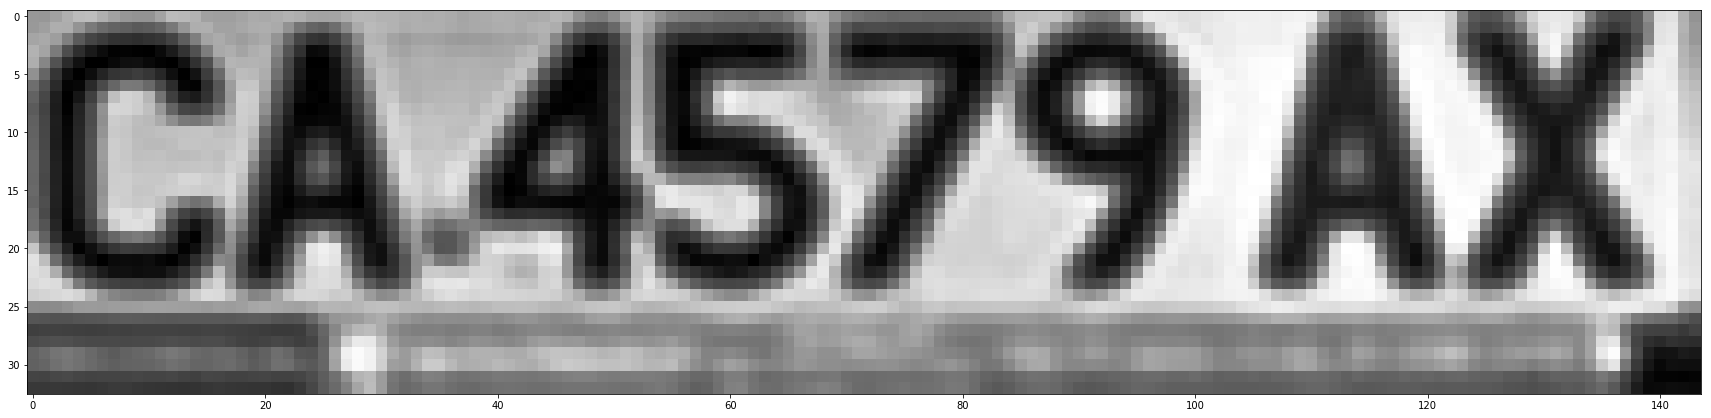

In [14]:
plate_example = cv2.imread("plates/0.jpg")
plate_example_rgb = cv2.cvtColor(plate_example, cv2.COLOR_BGR2RGB)
plt.imshow(plate_example)
plt.show()

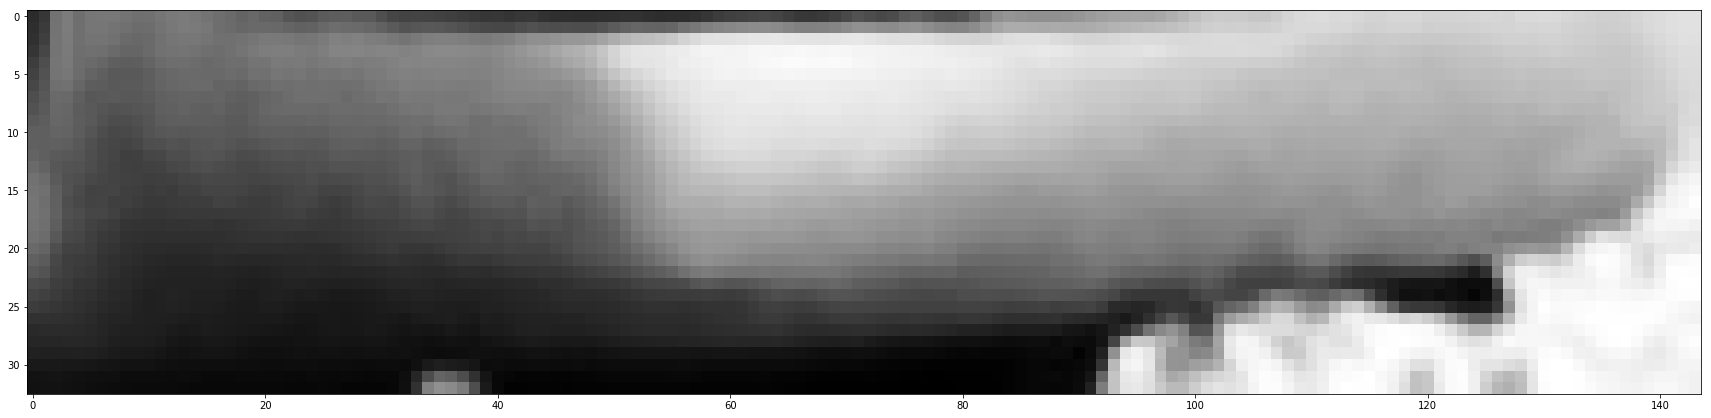

In [15]:
non_plate_example = cv2.imread("non_plates/0.jpg")
non_plate_example_rgb = cv2.cvtColor(non_plate_example, cv2.COLOR_BGR2RGB)
plt.imshow(non_plate_example_rgb)
plt.show()

### Зареждаме данните, трансформриаме ги в подходящ вид за трениране и тренираме модела.

In [16]:
def load_svm_data():
    training_images = []
    training_labels = []

    #load positive plates images
    img_mask = 'plates/*.jpg'
    img_names = glob(img_mask)
    for fn in img_names:
        #print('processing %s...' % fn,)
        img = cv2.imread(fn, 0)
        #print(np.shape(img))
        #print(type(img))
        img = img.flatten()
        #print(np.shape(img))
        #print(type(img))
        training_images.append(img)
        training_labels.append(1)
        
    #load negative plates images
    img_mask = 'non_plates/*.jpg'
    img_names = glob(img_mask)
    for fn in img_names:
        #print('processing %s...' % fn,)
        img = cv2.imread(fn, 0)
        #print(np.shape(img))
        img = img.flatten()
        #print(np.shape(img))
        training_images.append(img)
        training_labels.append(0)

    return training_images, training_labels

In [17]:
training_images, training_labels = load_svm_data()

In [18]:
training_data = np.array(training_images, np.float32)
training_classes = np.array(training_labels, np.int32)[:,np.newaxis]

In [19]:
print("training data shape = " + str(np.shape(training_data)))
print("training classes shape = " + str(np.shape(training_classes)))

training data shape = (135, 4752)
training classes shape = (135, 1)


In [20]:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setDegree(0.0)
svm.setGamma(1.0)
svm.setCoef0(0.0)
svm.setC(1)
svm.setNu(0.0)
svm.setP(0.0)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01))
svm.train(training_data, cv2.ml.ROW_SAMPLE, training_classes)

True

След като сме тренирали модела можем да пристъпим към класификацията на кандидатите за регистрационни табели и след това да ги сегментираме на отделни изображения за всеки символ.

In [21]:
def check_char_size(rect):
    height, width = rect.shape[:2]
    aspect_ratio = 45.0/75.0
    char_aspect_ratio = float(width) / (height + 0.0000000000000001)
    error = 0.35
    
    min_height = 15
    max_height = 28
    
    min_aspect_ratio = 0.2
    max_aspect_ratio = aspect_ratio + aspect_ratio * error
    
    char_area = np.count_nonzero(rect)
    image_area = width*height
    perc_pixels = char_area / image_area
    
    if((perc_pixels < 0.8) and (char_aspect_ratio > min_aspect_ratio) and (char_aspect_ratio < max_aspect_ratio)
       and (height >= min_height) and (height < max_height)):
        return True
    return False

In [22]:
def preprocess_char(segment):
    height, width = segment.shape[:2]
    transform_matrix = np.eye(2, 3, dtype=np.float32)
    m = max(width, height)
    transform_matrix[0][2] = (m/2) - (width/2)
    transform_matrix[1][2] = (m/2) - (height/2)
    
    warp_image = cv2.warpAffine(segment, transform_matrix, (m, m), cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, 0)
    show_image(warp_image)
    resized = cv2.resize(warp_image, (25,25))
    
    return resized

In [23]:
def segment_plate(image):
    chars = []
    result, image_threshold = cv2.threshold(image,60,255,cv2.THRESH_BINARY_INV)
    im2, contours, hierarchy = cv2.findContours(image_threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    result = cv2.cvtColor(image_threshold, cv2.COLOR_GRAY2RGB)

    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        #minBoundingRect = x,y,w,h
        #print(minBoundingRect)
        cv2.rectangle(result, (x,y), (x+w, y+h), (0,255,0))
        show_image(result)
        segment = image_threshold[y:y+h, x:x+w]
        #show_image(segment)
        if(check_char_size(segment)):
            #print("true")
            show_image(segment)
            chars.append(preprocess_char(segment))
            
    return chars

In [24]:
final_chars = []
for plate in final_plates:
    show_image(plate)
    test = plate.flatten()
    test = np.array([test], np.float32)
    if(svm.predict(test)[1][0][0] == 1.0):
        #print(np.shape(plate))
        temp_chars = segment_plate(plate)
        #print(np.shape(temp_chars))
        final_chars += temp_chars

In [ ]:
print(np.shape(final_chars))

Записваме всички символи като изображения с размер 25x25.

In [25]:
for i,char_img in enumerate(final_chars):
    print(np.shape(char_img))
    cv2.imwrite("char_" + str(i) + ".jpg", char_img)

(25, 25)
(25, 25)
(25, 25)
(25, 25)
(25, 25)
(25, 25)
(25, 25)
